In [1]:
import lequa2024 as lq

from quapy.method.non_aggregative import RFFM, DFM, RFF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import numpy as np

from collections import defaultdict

In [2]:
Source = lq.preprocess.create_LabelledCollection_from_documents(
        path="../data/T1.train_dev/T1/public/training_data.txt")
Target_generator = lq.data.gen_load_samples(
        path_dir="../data/T1.train_dev/T1/public/dev_samples", ground_truth_path=None, return_id=True
    )

scaler = MinMaxScaler()
Source.instances = scaler.fit_transform(Source.instances)

In [3]:
def relative_absolute_error(prevs, prevs_hat, eps=None):
    def __smooth(prevs, eps):
        n_classes = prevs.shape[-1]
        return (prevs + eps) / (eps * n_classes + 1)

    prevs = __smooth(prevs, eps)
    prevs_hat = __smooth(prevs_hat, eps)
    return (abs(prevs - prevs_hat) / prevs).mean(axis=-1)

#### RFFM

100%|██████████| 100/100 [00:02<00:00, 40.81it/s]


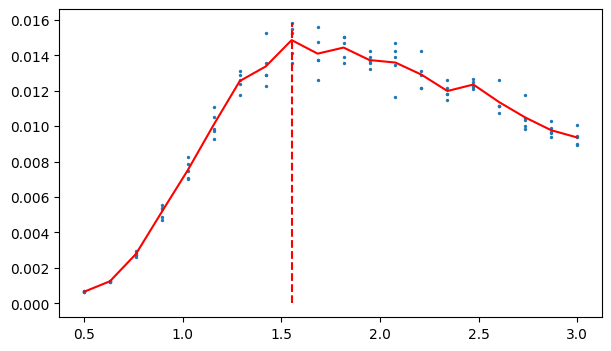

Sigma = 1.5526315789473684


In [4]:
rffm = RFFM(
    n_features=1000,
    seed=0x87,
    device=torch.device("cuda:0"),
)

rffm.fit(Source, sigma=np.linspace(0.5, 3, 20), verbose=True)

#### FC

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
class _FourierClassifierVectorisation:
        def __init__(self, n_classes, parameters) -> None:
            self.classifier = parameters["Classifier"]
            self.RFF = RFF(
                dim=n_classes,
                sigma=parameters["sigma"],
                n_features=parameters["n_features"],
                seed=parameters["seed"],
                device=parameters["device"],
            )

        def __call__(self, distribution):
            return self.RFF(self.classifier.predict_proba(distribution))
        
# fit the model
Source_train, Source_val = Source.split_random(
    train_prop=0.8, random_state=0x87
)
clf = LogisticRegression(max_iter=1000)
clf.fit(Source_train.instances, Source_train.labels)


LogisticRegression(max_iter=1000)

In [6]:
for sigma in np.linspace(0.1, 1, 20):
    parameters =  {
        "Classifier": clf,
        "sigma": sigma,
        "n_features" : 1000,
        "seed": 0x87,
        "device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    }
    vectorization = _FourierClassifierVectorisation(Source.n_classes, parameters)
    FourierClassifer = DFM(vectorization=vectorization)
    FourierClassifer.fit(Source)

    print(sigma, FourierClassifer.deltamin)

0.1 tensor(0.0088)
0.1473684210526316 tensor(0.0119)
0.19473684210526315 tensor(0.0137)
0.24210526315789474 tensor(0.0137)
0.2894736842105263 tensor(0.0129)
0.33684210526315794 tensor(0.0112)
0.38421052631578945 tensor(0.0094)
0.43157894736842106 tensor(0.0078)
0.4789473684210527 tensor(0.0065)
0.5263157894736842 tensor(0.0054)
0.5736842105263158 tensor(0.0046)
0.6210526315789474 tensor(0.0039)
0.6684210526315789 tensor(0.0033)
0.7157894736842105 tensor(0.0028)
0.7631578947368421 tensor(0.0025)
0.8105263157894737 tensor(0.0022)
0.8578947368421053 tensor(0.0019)
0.9052631578947369 tensor(0.0017)
0.9526315789473684 tensor(0.0015)
1.0 tensor(0.0014)
